In [1]:
!pip install Catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.0 MB/s eta 0:00:00


#Importing useful Libraries

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import joblib
import time
import re
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score,
    precision_recall_curve, confusion_matrix
)
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTEENN
import catboost as cb
from catboost import CatBoostClassifier

#Loading Data (Merging and Cleaning)

In [3]:
start_time = time.time()
intake_df = pd.read_excel('Intake.xlsx')
work_df = pd.read_excel('WO.xlsx')

intake_df['Opportunity ID'] = intake_df['Opportunity ID'].astype(str)
work_df['Opportunity ID'] = work_df['Opportunity ID'].astype(str)

merged_df = pd.merge(
    intake_df, work_df[['Opportunity ID','Roof Work Needed']],
    on='Opportunity ID', how='inner'
).dropna(subset=['Roof Work Needed'])
merged_df.head()

,Opportunity ID,Unnamed: 1,Opportunity Name,Intake Number,How old is the roof?,Number of Roof Layers,Type of Roofing,County,State,Created Date,Roof Work Needed
0,0068X00001Ij6rQ,NaN,Robert Fitton,I-039391,11-15 years,Unknown,Pitched roof,Bristol,MA,5/15/2023,No
1,0068X00001HrFvs,NaN,Zilola Bozorova meter 1,I-033568,6-10 years,1,Pitched roof,Brooklyn,NY,3/31/2023,Yes
2,0068X00001HbhQ8,NaN,Robert Mazzone,I-031411,11-15 years,1,Pitched roof,Rockingham,NH,3/14/2023,No
3,0068X00001HbhmC,NaN,Travis Cote,I-031274,0-5 years,1,Pitched roof,Hillsborough,NH,3/14/2023,No
4,0068X00001Hs4X8,NaN,Daniel Fisher,I-034421,Unknown,Unknown,Pitched roof,Cheshire,NH,4/5/2023,Yes


In [4]:
#Mapping Roof Yes = 1 and No = 0
merged_df['Roof Work Needed'] = merged_df['Roof Work Needed'].map({'Yes': 1, 'No': 0})

#Dropping Unnamed Columns
merged_df = merged_df.drop(columns=['Unnamed: 1'], errors='ignore')

#A bit of cleaning
most_frequent_type = merged_df.loc[merged_df['Type of Roofing'] != 'Unknown', 'Type of Roofing'].mode()[0]
merged_df['Type of Roofing'] = merged_df['Type of Roofing'].replace('Unknown', most_frequent_type)
merged_df = merged_df.dropna(subset=["Number of Roof Layers", "Roof Work Needed"]).reset_index(drop=True)

merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10796 entries, 0 to 10795
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Opportunity ID         10796 non-null  object 
 1   Opportunity Name       10796 non-null  object 
 2   Intake Number          10796 non-null  object 
 3   How old is the roof?   10796 non-null  object 
 4   Number of Roof Layers  10796 non-null  object 
 5   Type of Roofing        10796 non-null  object 
 6   County                 10796 non-null  object 
 7   State                  10796 non-null  object 
 8   Created Date           10796 non-null  object 
 9   Roof Work Needed       10796 non-null  float64
dtypes: float64(1), object(9)
memory usage: 843.6+ KB


#Visualizing the dataset
As we can see data is cleaned with 0 non null values, lets move on to visualization

Visualizing the target distribution

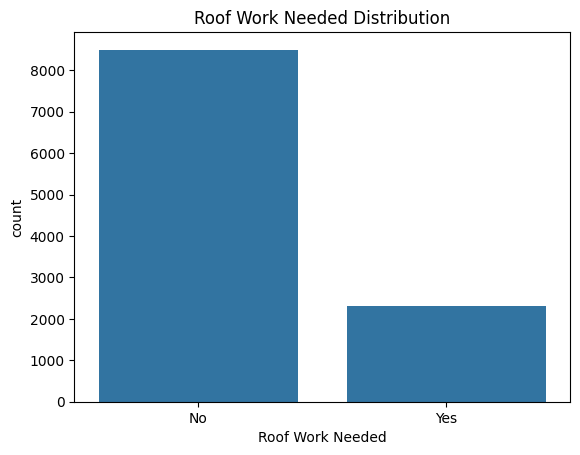

Roof Work Needed
0.0    0.786773
1.0    0.213227
Name: proportion, dtype: float64


In [5]:
sns.countplot(data=merged_df, x='Roof Work Needed')
plt.title('Roof Work Needed Distribution')
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

print(merged_df['Roof Work Needed'].value_counts(normalize=True))

Roof Age vs Roof work needed

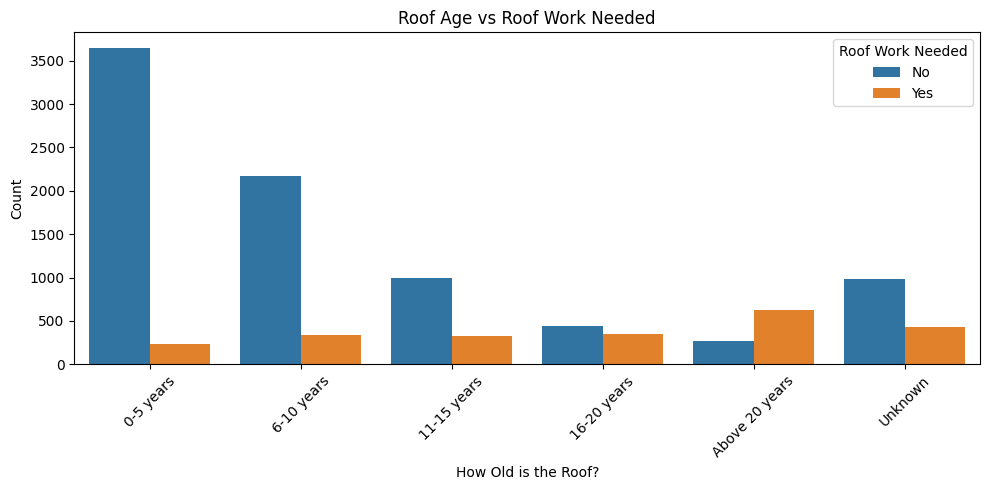

In [6]:
age_order = ['0-5 years', '6-10 years', '11-15 years', '16-20 years', 'Above 20 years','Unknown']

plt.figure(figsize=(10, 5))
sns.countplot(data=merged_df, x='How old is the roof?', hue='Roof Work Needed', order=age_order)
plt.title('Roof Age vs Roof Work Needed')
plt.xlabel('How Old is the Roof?')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Roof Work Needed', labels=['No', 'Yes'])
plt.tight_layout()
plt.show()

No. of roof layes vs Roof work needed

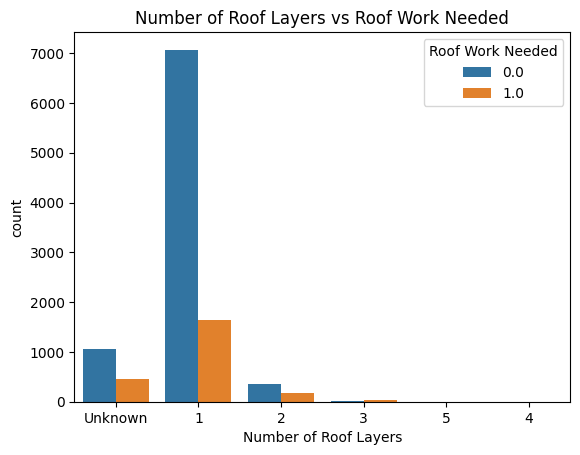

In [7]:
sns.countplot(data=merged_df, x='Number of Roof Layers', hue='Roof Work Needed')
plt.title('Number of Roof Layers vs Roof Work Needed')
plt.show()

Type of Roofing vs Roof work Needed

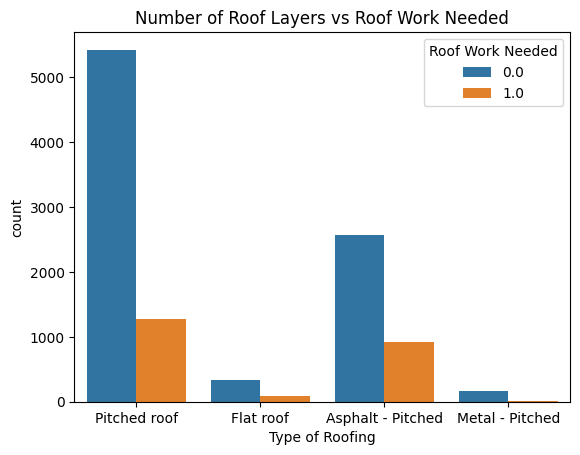

In [8]:
sns.countplot(data=merged_df, x='Type of Roofing', hue='Roof Work Needed')
plt.title('Number of Roof Layers vs Roof Work Needed')
plt.show()

Heatmap showing no. of layers and roof age with target

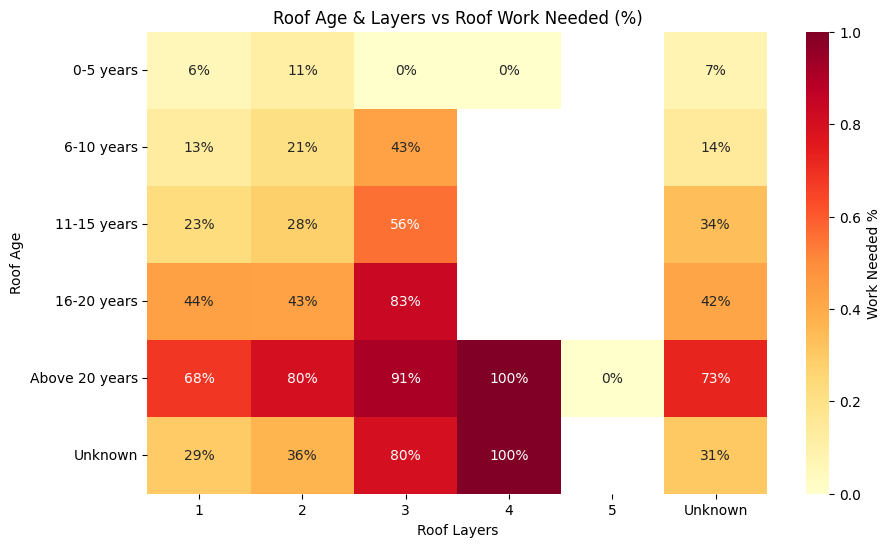

In [9]:
# Pivot table with mean of 'Roof Work Needed' (1 = Yes, 0 = No)
heatmap_data = merged_df.pivot_table(
    index='How old is the roof?',
    columns='Number of Roof Layers',
    values='Roof Work Needed',
    aggfunc='mean'
)

# Sorting the roof age categories
age_order = ['0-5 years', '6-10 years', '11-15 years', '16-20 years', 'Above 20 years', 'Unknown']
heatmap_data = heatmap_data.reindex(age_order)

# Plotting heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".0%", cmap="YlOrRd", cbar_kws={'label': 'Work Needed %'})
plt.title("Roof Age & Layers vs Roof Work Needed (%)")
plt.ylabel("Roof Age")
plt.xlabel("Roof Layers")
plt.show()

#Feature Engineering

We got a strong signal of features that could possible affect the target value:
1. Roof Age
2. No. of Layers
3. Type of Roofing
But these features won't be enough for the model to segregate between which features affect the target value most. So creating more features and Transforming so of the categorical columns

In [10]:
# ---------- Feature Engineering ----------
class FastFeatureEnricher(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    #Normaizing Type of Roofing
    def normalize_roof_type(self, val):
        if pd.isnull(val): return 'Unknown'
        val = val.lower().strip()
        if 'shingle' in val: return 'Shingle'
        if re.search(r'asphalt|arch', val): return 'Shingle'
        if 'tile' in val: return 'Tile'
        if 'metal' in val: return 'Metal'
        if 'flat' in val: return 'Flat'
        if any(x in val for x in ['unknown', 'other', 'n/a', 'na']): return 'Unknown'
        return 'Other'


    #Transforming the dataset by creating more features from 3 basic ones to help the model learn better
    def transform(self, X):
        df = X.copy()
        id_columns = ['Opportunity ID', 'Opportunity Name', 'Intake Number']
        df = df.drop(columns=[col for col in id_columns if col in df.columns])

        if 'Created Date' in df.columns:
            df['Created Date'] = pd.to_datetime(df['Created Date'], errors='coerce')
            df['intake_month'] = df['Created Date'].dt.month.fillna(6).astype(int)
            df['intake_weekday'] = df['Created Date'].dt.weekday.fillna(3).astype(int)
            df['intake_quarter'] = df['Created Date'].dt.quarter.fillna(2).astype(int)
            df['is_storm_season'] = df['intake_month'].isin([5,6,7,8,9]).astype(int)
            df.drop(columns=['Created Date'], inplace=True)

        age_map = {
            "0-5 years": 2.5, "6-10 years": 8.0, "11-15 years": 13.0,
            "16-20 years": 18.0, "Above 20 years": 25.0, "Unknown": 11.0
        }
        roof_age = df.get('How old is the roof?', pd.Series('Unknown', index=df.index))
        df['roof_age_num'] = roof_age.map(age_map).fillna(20.0)
        df['age_is_unknown'] = (roof_age == 'Unknown').astype(int)

        layers_map = {'1':1, '2':2, '3':3, '4':4, '5':5}
        roof_layers = df.get('Number of Roof Layers', pd.Series('Unknown', index=df.index)).astype(str)
        df['roof_layers_num'] = roof_layers.map(layers_map)
        df['layers_is_unknown'] = (roof_layers == 'Unknown').astype(int)
        df['roof_layers_num'] = df['roof_layers_num'].fillna(2)

        roof_type = df.get('Type of Roofing', pd.Series('Unknown', index=df.index)).astype(str)
        df['roof_type_norm'] = roof_type.apply(self.normalize_roof_type)

        df['is_old_roof'] = (df['roof_age_num'] >= 15).astype(int)
        df['is_very_old_roof'] = (df['roof_age_num'] >= 20).astype(int)
        df['has_multiple_layers'] = (df['roof_layers_num'] > 1).astype(int)
        df['roof_risk_score'] = df['roof_age_num'] * df['roof_layers_num']

        """Using County instead of state at this will give us more indepth and locallized view where the Roof work is needed.
        And Chosing Top - 10 which acted as high risk counties"""

        high_risk_counties = [
            'Queens', 'Fairfield', 'Westchester', 'Staten Island', 'Hartford',
            'New Haven', 'Middlesex', 'Brooklyn', 'Suffolk', 'Nassau'
        ]
        if 'County' in df.columns:
            df['high_risk_county'] = df['County'].isin(high_risk_counties).astype(int)
        else:
            df['high_risk_county'] = 0

        for rt in ['Shingle', 'Metal', 'Flat', 'Tile', 'Other']:
            colname = f'roof_type_is_{rt}'
            df[colname] = (df['roof_type_norm'] == rt).astype(int)
            df[f'roof_risk_score_x_{rt}'] = df['roof_risk_score'] * df[colname]

        #So now we have more than 20 features
        features = [
            'roof_age_num', 'age_is_unknown', 'roof_layers_num', 'layers_is_unknown',
            'is_old_roof', 'is_very_old_roof', 'has_multiple_layers', 'roof_risk_score',
            'high_risk_county', 'intake_month', 'intake_weekday', 'intake_quarter',
            'is_storm_season',
            'roof_type_is_Shingle', 'roof_type_is_Metal', 'roof_type_is_Flat', 'roof_type_is_Tile', 'roof_type_is_Other',
            'roof_risk_score_x_Shingle', 'roof_risk_score_x_Metal', 'roof_risk_score_x_Flat', 'roof_risk_score_x_Tile', 'roof_risk_score_x_Other'
        ]
        return df[features]

# Spliting the Dataset

In [11]:

X = merged_df.drop(columns=['Roof Work Needed']).copy()
y = merged_df['Roof Work Needed'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

Merging the splitted dataset with our Feature Enricher

In [12]:
enricher = FastFeatureEnricher()
X_train_fe = enricher.fit_transform(X_train, y_train)
X_test_fe = enricher.transform(X_test)

all_features = X_train_fe.columns.tolist()

#Model Pipeline


In [13]:
# Threshold Helper
def optimal_recall_threshold(y_true, y_probs, min_precision=0.45):
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_probs)
    recalls = recalls[:-1]
    precisions = precisions[:-1]
    valid = precisions >= min_precision
    idx = np.argmax(recalls * valid)
    return float(thresholds[idx]), float(recalls[idx]), float(precisions[idx])

In [14]:
def make_pipeline(clf):
    return ImbPipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('balance', SMOTEENN(random_state=42)),
        ('model', clf)
    ])

# Defining two model pipelines for tuning
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
cb = cb.CatBoostClassifier(verbose=0, random_seed=42)

rf_pipeline = make_pipeline(rf)
cb_pipeline = make_pipeline(cb)

# Hyperparameter grids for tuning
param_rf = {
    'model__n_estimators': [100, 300, 500],
    'model__max_depth': [8, 10, 12, None],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

param_cb = {
    'model__depth': [4, 6, 8, 10],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__l2_leaf_reg': [1, 3, 5, 7],
    'model__iterations': [100, 300, 500]
}

print("Starting hyperparameter tuning Random Forest...")
search_rf = RandomizedSearchCV(rf_pipeline, param_rf, n_iter=100, cv=3, scoring='recall',
                              verbose=2, n_jobs=-1, random_state=42)
search_rf.fit(X_train_fe, y_train)
print("Best RF params:", search_rf.best_params_)
print("Best RF recall:", search_rf.best_score_)

print("Starting hyperparameter tuning CatBoost...")
search_cb = RandomizedSearchCV(cb_pipeline, param_cb, n_iter=100, cv=3, scoring='recall',
                              verbose=2, n_jobs=-1, random_state=42)
search_cb.fit(X_train_fe, y_train)
print("Best CB params:", search_cb.best_params_)
print("Best CB recall:", search_cb.best_score_)

Starting hyperparameter tuning Random Forest...
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best RF params: {'model__n_estimators': 500, 'model__min_samples_split': 5, 'model__min_samples_leaf': 4, 'model__max_depth': 8}
Best RF recall: 0.6659466534885657
Starting hyperparameter tuning CatBoost...
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best CB params: {'model__learning_rate': 0.01, 'model__l2_leaf_reg': 1, 'model__iterations': 100, 'model__depth': 4}
Best CB recall: 0.7267979517263489


So here are our list of top 15 Features

In [15]:
# Feature Selection (using RF feature importances)
best_rf = search_rf.best_estimator_
importances = best_rf.named_steps['model'].feature_importances_
feat_importance = pd.Series(importances, index=all_features).sort_values(ascending=False)
print("\nTop 15 feature importances:")
print(feat_importance.head(15))


Top 15 feature importances:
roof_age_num                 0.252880
roof_risk_score              0.222372
is_old_roof                  0.141182
roof_risk_score_x_Shingle    0.087158
roof_risk_score_x_Other      0.064516
is_very_old_roof             0.058966
intake_month                 0.029237
intake_weekday               0.025816
roof_layers_num              0.016256
age_is_unknown               0.014569
has_multiple_layers          0.013593
intake_quarter               0.013280
roof_type_is_Shingle         0.012642
roof_type_is_Other           0.009602
roof_risk_score_x_Flat       0.008666
dtype: float64


Optionally select top-k features


In [16]:
top_k = 15
selected_features = feat_importance.head(top_k).index.tolist()
print(f"\nSelected top {top_k} features for further modeling.")

X_train_selected = X_train_fe[selected_features]
X_test_selected = X_test_fe[selected_features]

def extract_model_params(param_dict, prefix='model__'):
    return {k[len(prefix):]: v for k, v in param_dict.items() if k.startswith(prefix)}


Selected top 15 features for further modeling.


Retraining models on selected features

In [17]:
fixed_rf_params = extract_model_params(search_rf.best_params_, prefix='model__')
fixed_cb_params = extract_model_params(search_cb.best_params_, prefix='model__')

best_rf_selected = make_pipeline(RandomForestClassifier(**fixed_rf_params, random_state=42, n_jobs=-1))
best_cb_selected = make_pipeline(CatBoostClassifier(**fixed_cb_params, verbose=0, random_seed=42))

best_rf_selected.fit(X_train_selected, y_train)
best_cb_selected.fit(X_train_selected, y_train)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('balance', SMOTEENN(random_state=42)),
                ('model',
                 <catboost.core.CatBoostClassifier object at 0x78c146af6ea0>)])

In [18]:
# Stacking Ensemble with selected features
estimators = [
    ('rf', best_rf_selected),
    ('cb', best_cb_selected)
]

stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=1000, random_state=42),
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    n_jobs=-1,
    passthrough=True
)

stacking_clf.fit(X_train_selected, y_train)

# Threshold calibration function
def calibrate_and_predict(clf, X_val, y_val, min_precision=0.45):
    y_probs = clf.predict_proba(X_val)[:,1]
    th, recall, precision = optimal_recall_threshold(y_val, y_probs, min_precision)
    y_pred = (y_probs >= th).astype(int)
    return y_pred, y_probs, th, recall, precision


#Evaluating each model with threshold calibration
print("\nEvaluating final models with threshold calibration...\n")

models = {
    'RandomForest': (best_rf_selected, X_test_selected),
    'CatBoost': (best_cb_selected, X_test_selected),
    'Stacking': (stacking_clf, X_test_selected)
}

results = {}

for name, (model, X_eval) in models.items():
    y_pred, y_probs, th, recall, precision = calibrate_and_predict(model, X_eval, y_test)
    roc_auc = roc_auc_score(y_test, y_probs)
    pr_auc = average_precision_score(y_test, y_probs)
    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    results[name] = {
        "ROC-AUC": roc_auc,
        "PR-AUC": pr_auc,
        "F1": f1,
        "Precision": precision,
        "Recall": recall,
        "Threshold": th,
        "tp": tp,
        "fp": fp,
        "fn": fn,
        "tn": tn,
    }
    print(f"📊 {name} Evaluation")
    print(f"ROC-AUC: {roc_auc:.3f} | PR-AUC: {pr_auc:.3f}")
    print(f"Recall: {recall:.3f} (Threshold: {th:.3f}), Precision: {precision:.3f}, F1: {f1:.3f}")
    print(f"Confusion matrix: TP={tp}, FP={fp}, FN={fn}, TN={tn}")

print(f"\n⏱️ Total runtime: {(time.time() - start_time)/60:.1f} min")



Evaluating final models with threshold calibration...

📊 RandomForest Evaluation
ROC-AUC: 0.794 | PR-AUC: 0.552
Recall: 0.679 (Threshold: 0.346), Precision: 0.450, F1: 0.542
Confusion matrix: TP=313, FP=382, FN=148, TN=1317
📊 CatBoost Evaluation
ROC-AUC: 0.797 | PR-AUC: 0.557
Recall: 0.688 (Threshold: 0.427), Precision: 0.450, F1: 0.544
Confusion matrix: TP=317, FP=387, FN=144, TN=1312
📊 Stacking Evaluation
ROC-AUC: 0.799 | PR-AUC: 0.565
Recall: 0.725 (Threshold: 0.232), Precision: 0.450, F1: 0.555
Confusion matrix: TP=334, FP=408, FN=127, TN=1291

⏱️ Total runtime: 28.3 min


#Saving the Stacking model in pickle file with complete pipeline

In [19]:
from sklearn.pipeline import Pipeline
import joblib

# A transformer that selects only the top features
from sklearn.base import BaseEstimator, TransformerMixin

class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, features):
        self.features = features
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.features]

# Build final pipeline
pipe = Pipeline([
    ("enricher", FastFeatureEnricher()),   # feature engineering
    ("selector", FeatureSelector(selected_features)),  # top-k features
    ("model", stacking_clf)                # trained stacking model
])

# Refit on raw training data (X_train, y_train)
pipe.fit(X_train, y_train)

# Save the pipeline
joblib.dump(pipe, "stacking_roof_model.pkl")
print("✅ Stacking pipeline saved as 'stacking_roof_model.pkl'")


✅ Stacking pipeline saved as 'stacking_roof_model.pkl'


In [20]:
# Save all necessary pieces
joblib.dump({
    "stacking_model": stacking_clf,         # or pipe if you use a full Pipeline
    "selected_features": selected_features,
    "enricher": enricher
}, "stacking_roof_model1.pkl")
print("✅ Stacking pipeline saved as 'stacking_roof_model1.pkl'")

✅ Stacking pipeline saved as 'stacking_roof_model1.pkl'


In [21]:
joblib.dump({
    "catboost_model": best_cb_selected,
    "selected_features": selected_features,
    "enricher": enricher
}, "catboost_roof_model.pkl")
print("✅ Stacking pipeline saved as 'catboost_model.pkl'")

✅ Stacking pipeline saved as 'catboost_model.pkl'
